# Kernel Density Estimation

*Kernel density estimation* (KDE) is in some senses an algorithm which takes the mixture-of-Gaussians idea to its logical extreme: it uses a mixture consisting of one Gaussian component *per point*, resulting in an essentially non-parametric estimator of density.
In this section, we will explore the motivation and uses of KDE.

We begin with the standard imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Motivating KDE: Histograms

As already discussed, a density estimator is an algorithm which seeks to model the probability distribution that generated a dataset.

For example, let's create some data that is drawn from two normal distributions:

In [2]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

x = make_data(1000)

We have previously seen that the standard count-based histogram can be created with the ``plt.hist()`` function.
By specifying the ``normed`` parameter of the histogram, we end up with a normalized histogram where the height of the bins does not reflect counts, but instead reflects probability density:

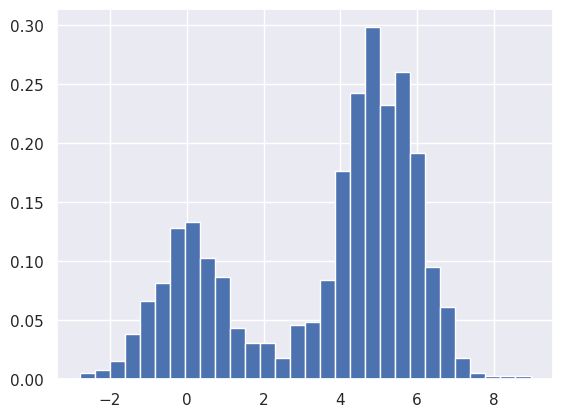

In [3]:
hist = plt.hist(x, bins=30, density=True)

Notice that for equal binning, this normalization simply changes the scale on the y-axis, leaving the relative heights essentially the same as in a histogram built from counts.
This normalization is chosen so that the total area under the histogram is equal to 1, as we can confirm by looking at the output of the histogram function:

In [4]:
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
(density * widths).sum()

1.0

One of the issues with using a histogram as a density estimator is that the choice of bin size and location can lead to representations that have qualitatively different features.
For example, if we look at a version of this data with only 20 points, the choice of how to draw the bins can lead to an entirely different interpretation of the data!
Consider this example:

In [5]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)

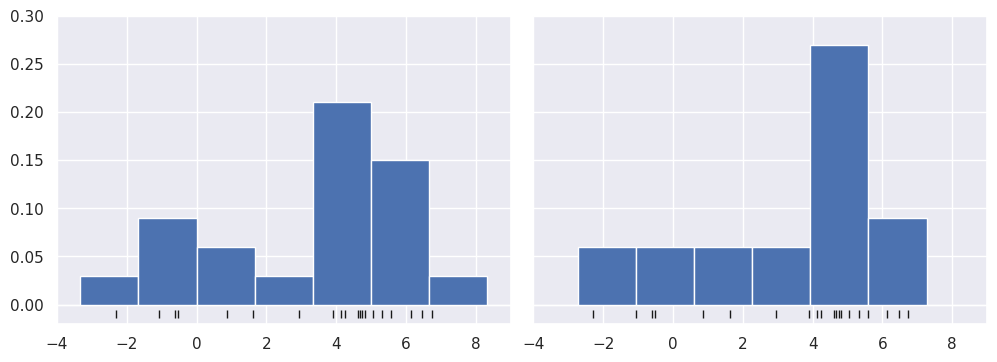

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4),
                       sharex=True, sharey=True,
                       subplot_kw={'xlim':(-4, 9),
                                   'ylim':(-0.02, 0.3)})
fig.subplots_adjust(wspace=0.05)
for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins=bins + offset, density=True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k',
               markeredgewidth=1)

On the left, the histogram makes clear that this is a bimodal distribution.

Stepping back, we can think of a histogram as a stack of blocks, where we stack one block within each bin on top of each point in the dataset.

Let's view this directly:

(-0.2, 8.0)

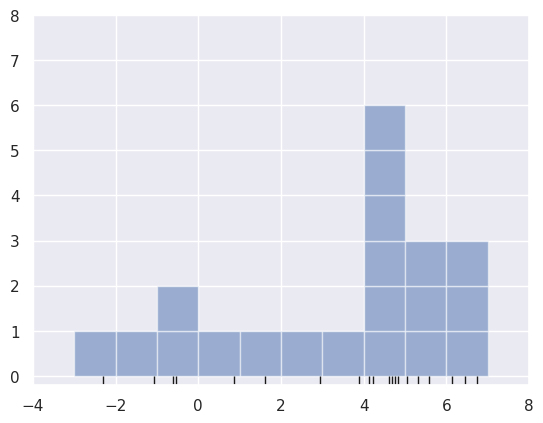

In [7]:
fig, ax = plt.subplots()
bins = np.arange(-3, 8)
ax.plot(x, np.full_like(x, -0.1), '|k',
        markeredgewidth=1)
for count, edge in zip(*np.histogram(x, bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle((edge, i), 1, 1,
                                   alpha=0.5))
ax.set_xlim(-4, 8)
ax.set_ylim(-0.2, 8)

The problem with our two binnings stems from the fact that the height of the block stack often reflects not on the actual density of points nearby, but on coincidences of how the bins align with the data points.

If we do this, the blocks won't be aligned, but we can add their contributions at each location along the x-axis to find the result.

Let's try this:

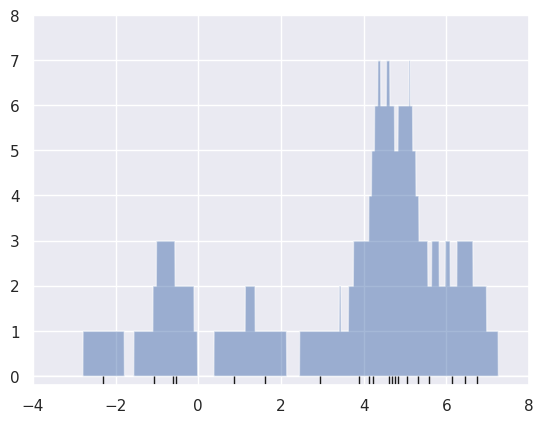

In [8]:
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 8]);

The result looks a bit messy, but is a much more robust reflection of the actual data characteristics than is the standard histogram.

Let's use a standard normal curve at each point instead of a block:

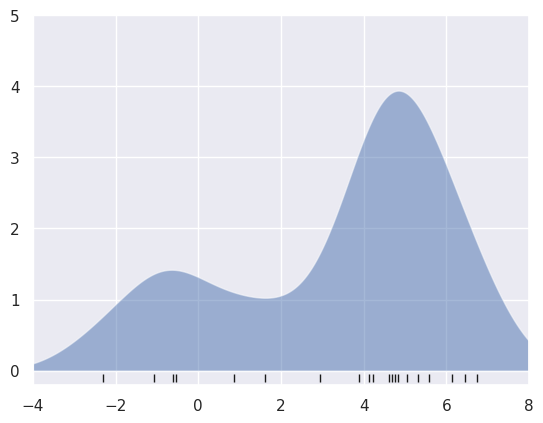

In [9]:
from scipy.stats import norm
x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 5]);

This smoothed-out plot, with a Gaussian distribution contributed at the location of each input point, gives a much more accurate idea of the shape of the data distribution, and one which has much less variance.

## Kernel Density Estimation in Practice

The kernel bandwidth, which is a free parameter, can be determined using Scikit-Learn's standard cross validation tools as we will soon see.

Let's first show a simple example of replicating the above plot using the Scikit-Learn ``KernelDensity`` estimator:

(-0.02, 0.22)

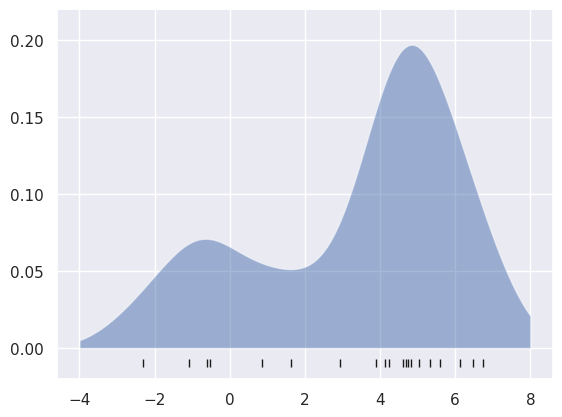

In [10]:
from sklearn.neighbors import KernelDensity

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(x[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22)

The result here is normalized such that the area under the curve is equal to 1.

### Selecting the bandwidth via cross-validation

Because we are looking at such a small dataset, we will use leave-one-out cross-validation, which minimizes the reduction in training set size for each cross-validation trial:

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())
grid.fit(x[:, None]);

Now we can find the choice of bandwidth which maximizes the score (which in this case defaults to the log-likelihood):

In [12]:
grid.best_params_

{'bandwidth': 1.1233240329780276}

The optimal bandwidth happens to be very close to what we used in the example plot earlier, where the bandwidth was 1.0